# Computing $T_{eff}$ for EBTEL-2fluid Runs: Emission from Electron and Ion Heating Cases

In [38]:
import sys
import os
from imp import reload
from scipy.optimize import curve_fit
import numpy as np
import astropy.constants as ac
import seaborn.apionly as sns
import matplotlib.pyplot as plt
%matplotlib inline
sys.path.append('/home/wtb2/Documents/sunFM/')
sys.path.append('/home/wtb2/Documents/EBTEL_analysis/src/')
sys.path.append('/home/wtb2/Documents/EBTEL_C/bin/')
import ebtel_configure as ebc
import ebtel_plot as ebp
import ebtel_run as tf_run
import ebtel_plot as ebp
import ebtel_wrapper as sf_wrap
import em_binner as emb
reload(emb)

/usr/lib/python3/dist-packages/matplotlib/__init__.py:1175: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'em_binner' from '/home/wtb2/Documents/sunFM/em_binner.py'>

We will compute emission measure distributions for sample EBTEL runs for single-pulse heating functions with $Q=10^{26}$ erg, $\tau=100$ s, $L=40$ Mm, $\beta=1$, for electron, ion, and single-fluid heating cases where the total time $T$ will be approximately the cooling/draining timescale. 

First, compute each of the EBTEL runs. Then compute $T_{eff}$ using the `Ion_Pop_Solver` code and construct emission measure distributions for both $T$ and $T_{eff}$.

Configure file inputs.

In [39]:
#input dictionary
config_dict = {'usage_option':'dem','rad_option':'rk','dem_option':'new','heat_flux_option':'limited',
              'solver':'euler','ic_mode':'st_eq','print_plasma_params':'True'}
config_dict['total_time'] = 5000
config_dict['tau'] = 1.0
config_dict['rka_error'] = 1.0e-6
config_dict['index_dem'] = 451
config_dict['sat_limit'] = 1.0
config_dict['h_back'] = 3.4e-6
config_dict['heating_shape'] = 'triangle'
config_dict['t_start_switch'] = 'uniform'
config_dict['t_end_switch'] = 'uniform'
config_dict['T0'] = 1.0e+6
config_dict['n0'] = 1.0e+8
config_dict['t_start'] = 0.0
config_dict['mean_t_start'] = 1000
config_dict['std_t_start'] = 1000
config_dict['amp_switch'] = 'uniform'
config_dict['amp0'] = 0.001
config_dict['amp1'] = 0.01
config_dict['alpha'] = 1.5
config_dict['loop_length'] = 40.0
config_dict['num_events'] = 1
config_dict['t_pulse_half'] = 50.0
config_dict['h_nano'] = config_dict['total_time']/config_dict['t_pulse_half']*8e-3 #triangular heat pulses

The next two lines are the only ones we'll change between trials.

In [40]:
config_dict['heat_species'] = 'electron'
config_dict['output_file'] = '/home/wtb2/Documents/research_notebook/EBTEL/ebtel_data/hp2_sp-test-case_%s'%(config_dict['heat_species'])

Print the configuration files.

In [41]:
conf = ebc.Configurer(config_dict,'')
conf.print_xml_config(config_file=config_dict['output_file']+'.xml')

Now, run the code for the electron, ion, and single-fluid cases.

In [42]:
tf_runner = tf_run.Runner('/home/wtb2/Documents/EBTEL-2fluid_repo/bin/','')
#electron
el_out = config_dict['output_file']
tf_runner.run_ebtel_single(config_dict['output_file']+'.xml')
#ion
config_dict['heat_species'] = 'ion'
config_dict['output_file'] = '/home/wtb2/Documents/research_notebook/EBTEL/ebtel_data/hp2_sp-test-case_%s'%(config_dict['heat_species'])
ion_out = config_dict['output_file']
conf = ebc.Configurer(config_dict,'')
conf.print_xml_config(config_file=config_dict['output_file']+'.xml')
tf_runner.run_ebtel_single(config_dict['output_file']+'.xml')
#single-fluid
config_dict['heat_species'] = 'single'
config_dict['output_file'] = '/home/wtb2/Documents/research_notebook/EBTEL/ebtel_data/hp2_sp-test-case_%s'%(config_dict['heat_species'])
single_out = config_dict['output_file']
conf = ebc.Configurer(config_dict,'')
conf.print_xml_config(config_file=config_dict['output_file']+'.xml')
sf_wrap.run_ebtel('/home/wtb2/Documents/EBTEL_C/bin/','',
                 config_file=config_dict['output_file']+'.xml')

************************************************************************************
            Enthalpy Based Thermal Evolution of Loops (EBTEL)						
			   Two-fluid Model											
************************************************************************************

Original single-fluid code written in IDL by J.A. Klimchuk, S. Patsourakos, P.J. Cargill
See Klimchuk, J.A, S. Patsourakos & P.J. Cargill 2008, ApJ 682:1351-2362
See also Cargill, P.J., S.J. Bradshaw & J.A. Klimchuk 2012, ApJ 752:161-174

Translation into the C Programming Language by Will Barnes,
Dept. of Physics & Astronomy, Rice University (2014)
************************************************************************************

INPUTS
------
Total time: 5000 s
Time step: 1.000000 s
Loop half-length: 40.000000 Mm
Usage option(see documentation): dem
Heating pulse shape: triangle
Heating species: electron
Solving equations using Euler method
Using Raymond-Klimchuk Loss Function
Using limited method to calculate the

Do a quick plot to show $T,n$ profiles.

Unable to load heating event amplitudes.


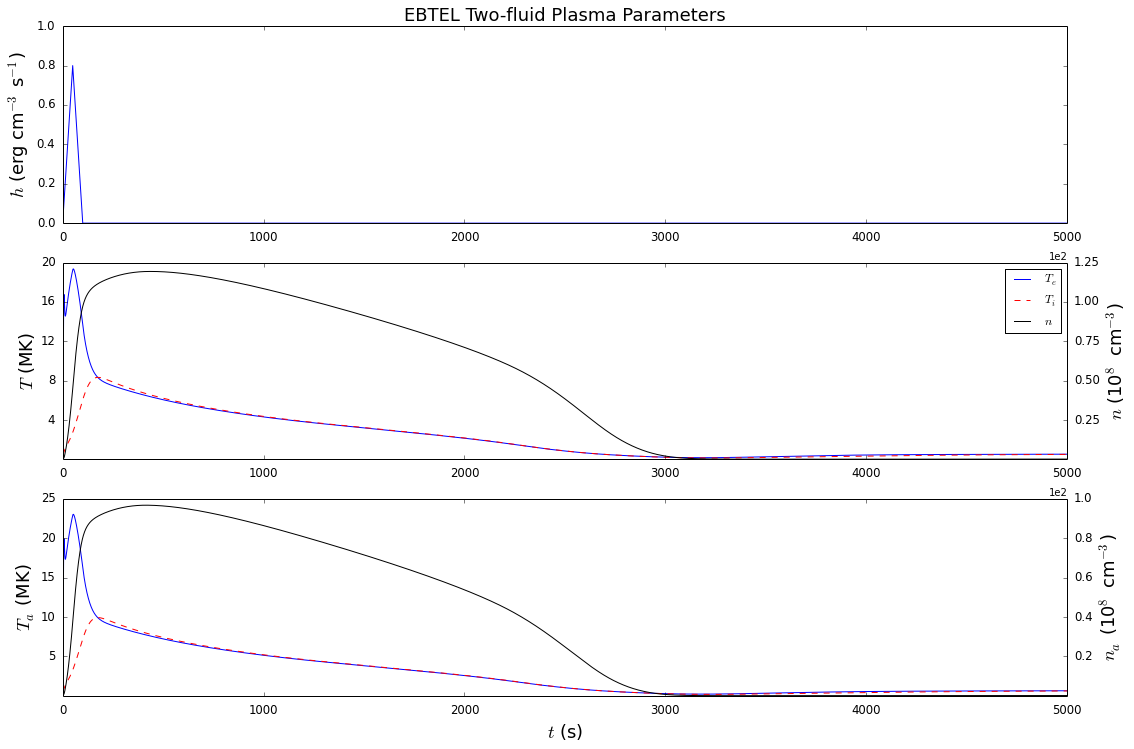

In [43]:
plotter=ebp.Plotter(parent_dir='',child=el_out)
plotter.plot_params()

Read in the data and print to files to be read by `Ion_Pop_Solver` code.

In [44]:
dat = np.loadtxt(el_out+'.txt')
np.savetxt(el_out+'_T_n_profile.txt',np.transpose([dat[:,0],dat[:,1],dat[:,3]]),
           header=str(len(dat[:,0])),comments='',fmt='%f\t%e\t%e')
dat = np.loadtxt(ion_out+'.txt')
np.savetxt(ion_out+'_T_n_profile.txt',np.transpose([dat[:,0],dat[:,1],dat[:,3]]),
           header=str(len(dat[:,0])),comments='',fmt='%f\t%e\t%e')
dat = np.loadtxt(single_out+'.txt')
np.savetxt(single_out+'_T_n_profile.txt',np.transpose([dat[:,0],dat[:,1],dat[:,2]]),
           header=str(len(dat[:,0])),comments='',fmt='%f\t%e\t%e')

Run the `Ion_Pop_Solver` code for the three sets of $n(t),T(t)$ profiles (external).

Define some functions to streamline plot building.

In [45]:
def tick_maker(old_ticks,n):
    if n < 2:
        raise ValueError('n must be greater than 1')
        
    n = n-1
    delta = (old_ticks[-1] - old_ticks[0])/n
    new_ticks = []
    for i in range(n):
        new_ticks.append(old_ticks[0] + i*delta)
        
    new_ticks.append(old_ticks[0] + n*delta)
    return new_ticks

def ion_pop_t_plotter(filename,**kwargs):
    #load file
    data = np.loadtxt(filename)
    #get relevant data
    t = data[:,0]
    T = data[:,1]
    Teff = data[:,2]
    n = data[:,3]
    
    #set up figure
    fig = plt.figure(figsize=(8,4))
    ax = fig.gca()
    #plot
    line_t = ax.plot(t,T/1e+6,color='k',linestyle='-',
                             label=r'$T$',linewidth=2)
    line_teff = ax.plot(t,Teff/1e+6,color='k',linestyle='--',label=r'$T_{eff}$',linewidth=2)
    ax_n = ax.twinx()
    line_n = ax_n.plot(t,n/1e+8,label=r'$n$',color='k',linestyle='-.',linewidth=2)
    #scale and limits
    ax.set_xscale('log')
    ax_n.set_xscale('log')
    #labels
    ax.set_ylabel(r'$T$ $\mathrm{(MK)}$',fontsize=22)
    ax.set_xlabel(r'$t$ $\mathrm{(s)}$',fontsize=22)
    ax_n.set_ylabel(r'$n$ $(10^8 \mathrm{cm}^{-3})$',fontsize=22)
    #aesthetics
    ax.set_ylim([0,25])
    ax.set_xlim([t[0],t[-1]])
    ax_n.set_xlim([t[0],t[-1]])
    #ax.set_xticks(tick_maker(ax.get_xticks(),5))
    ax.set_yticks(tick_maker(ax.get_yticks(),6))
    ax_n.set_yticks(tick_maker(ax_n.get_yticks(),4))
    ax.tick_params(axis='both',labelsize=0.65*22,pad=8)
    ax_n.tick_params(axis='both',labelsize=0.65*22,pad=8)
    #legend
    lines = line_n + line_t + line_teff
    labels = [l.get_label() for l in lines]
    ax.legend(lines,labels,loc=2,fontsize=0.65*22)
    #show or print
    plt.tight_layout()
    if 'fn' in kwargs:
        plt.savefig(kwargs['fn'],format='pdf',dpi=1000)
    else:
        plt.show()
    
def mini_fitter(logT,logEM,cool_lims=[6.0,6.6],cutoff=23.0):
    #Interpolate
    inf_index = np.where(logEM > cutoff)
    logT_new = np.linspace(logT[inf_index[0][0]],logT[inf_index[0][-1]],
                          2000)
    logEM_new = np.interp(logT_new,logT[inf_index[0][0]:inf_index[0][-1]],
                         logEM[inf_index[0][0]:inf_index[0][-1]])
    #Find hot limits
    i_hot = np.where(logT_new > logT_new[np.argmax(logEM_new)])[0]
    logT_hot = logT_new[i_hot]
    logEM_hot = logEM_new[i_hot]
    hot_lims = []
    hot_lims.append(logT_new[i_hot[np.where(logEM_hot>0.99*np.max(logEM_new))[0]][-1]])
    dlogEMdlogT_hot = np.gradient(logEM_hot,np.gradient(logT_hot))
    i_hot = np.where(np.fabs(dlogEMdlogT_hot)>11.0)
    if len(i_hot[0]) <= 1:
        print("Cannot find upper limit for |dlogEM/dlogT| > 10; using logT=7.2")
        hot_lims.append(7.2)
    else:
        hot_lims.append(logT_hot[i_hot[0][0]-1])
    #Get cool and hot arrays
    #cool
    icl = np.where(logT_new<cool_lims[0])
    icu = np.where(logT_new>cool_lims[-1])
    if len(icl[0]) > 0 and len(icu[0]) > 0:
        logT_new_cool = logT_new[(icl[0][-1] + 1):(icu[0][0] - 1)]
        logEM_new_cool = logEM_new[(icl[0][-1] + 1):(icu[0][0] - 1)]
    else:
        logT_new_cool = False
        logEM_new_cool = False
    #hot
    ihl = np.where(logT_new<hot_lims[0])
    ihu = np.where(logT_new>hot_lims[-1])
    if len(ihl[0]) > 0 and len(ihu[0]) > 0:
        logT_new_hot = logT_new[(ihl[0][-1] + 1):(ihu[0][0] - 1)]
        logEM_new_hot = logEM_new[(ihl[0][-1] + 1):(ihu[0][0] - 1)]
    else:
        logT_new_hot = False
        logEM_new_hot = False
    #define linear function to fit to
    def linear_fit(x,a,b):
        return a*x + b
    #do linear fit
    #cool
    if logT_new_cool is False:
        ac = False
        bc = False
    else:
        pars,covar = curve_fit(linear_fit,logT_new_cool,logEM_new_cool)
        ac,bc = pars[0],pars[1]
    #hot
    if logT_new_hot is False:
        ah = False
        bh = False
    else:
        pars,covar = curve_fit(linear_fit,logT_new_hot,logEM_new_hot)
        ah,bh = pars[0],pars[1]
        
    #return temperature vectors and fit parameters
    return logT_new_cool,[ac,bc],logT_new_hot,[ah,bh]

def plot_derivs(logT,logEM,logEM_eff,**kwargs):
    #regular
    i_filter = np.where(logEM>23.0)
    logEM_cleaned = np.array(logEM[i_filter[0]])
    logT_cleaned = np.array(logT[i_filter[0]])
    dEMdT = np.gradient(logEM_cleaned,np.gradient(logT_cleaned))
    #effective
    i_filter = np.where(logEM_eff>23.0)
    logEM_cleaned_eff = np.array(logEM_eff[i_filter[0]])
    logT_cleaned_eff = np.array(logT[i_filter[0]])
    dEMdT_eff = np.gradient(logEM_cleaned_eff,np.gradient(logT_cleaned_eff))
    #plotting
    fig = plt.figure(figsize=(8,4))
    ax = fig.gca()
    ax.plot(logT_cleaned,dEMdT,'-k',label=r'$T$')
    ax.plot(logT_cleaned_eff,dEMdT_eff,'--k',label=r'$T_{eff}$')
    #labels
    ax.set_xlabel(r'$\log{T}$ $\mathrm{(K)}$',fontsize=22)
    ax.set_ylabel(r'$d\log{\mathrm{EM}}/d\log{T}$',fontsize=22)
    ax.axhline(y=2,color='k',linestyle=':')
    ax.axhline(y=3,color='k',linestyle=':')
    ax.axhline(y=-2.5,color='k',linestyle=':')
    ax.axhline(y=-5.5,color='k',linestyle=':')
    #styling
    ax.set_ylim([-10,6])
    ax.set_xlim([5.5,7.5])
    ax.set_yticks(tick_maker(ax.get_yticks(),5))
    ax.tick_params(axis='both',pad=8,labelsize=0.65*22)
    #legend
    ax.legend(loc='best',fontsize=0.65*22)
    #show or save
    plt.tight_layout()
    if 'fn' in kwargs:
        plt.savefig(kwargs['fn'],format='pdf',dpi=1000)
    else:
        plt.show()

Now, let's calculate the $\mathrm{EM}$ distributions using both $T$ and $T_{eff}$ for our three cases.

Define a mini fitter function so that we can quickly fit the hot and cool slopes.

Use $\mathrm{EM}$ values for $T$ and $T_{eff}$ to do fits to both sets of emission measure curves for all three example cases.

Temperature bins not yet created. Building now with default values.


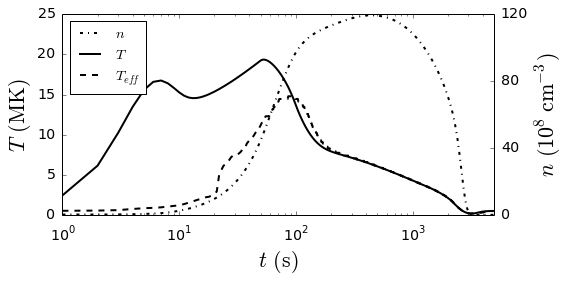

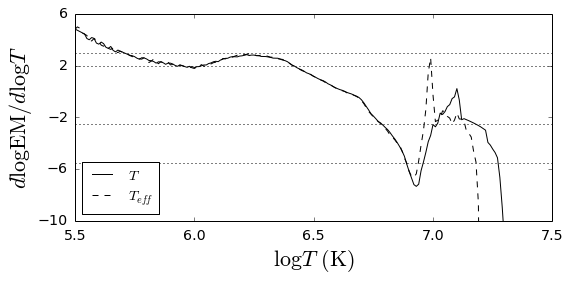

In [46]:
#electron
binner = emb.EM_Binner('ebtel_data/hp2_sp-test-case_electron_teff.txt',2*40.0e+8)
binner.build_em_dist()
#reduce by 10 for aspect ratio factor
binner.em = binner.em - 1.0
elem = [binner.logT_EM,binner.em,binner.time,binner.temp,binner.density]
binner.em_eff = binner.em_eff - 1.0
#profiles
ion_pop_t_plotter('ebtel_data/hp2_sp-test-case_electron_teff.txt')#,
                 #fn='/home/wtb2/Documents/papers/hot_non-flaring_plasma_2/figures/teff_electron_profiles.pdf')
#derivatives
plot_derivs(binner.logT_EM,binner.em,binner.em_eff)
#fitting
logTc,pc,logTh,ph = mini_fitter(binner.logT_EM,binner.em)
logTc_eff,pc_eff,logTh_eff,ph_eff = mini_fitter(binner.logT_EM,
                                                binner.em_eff)

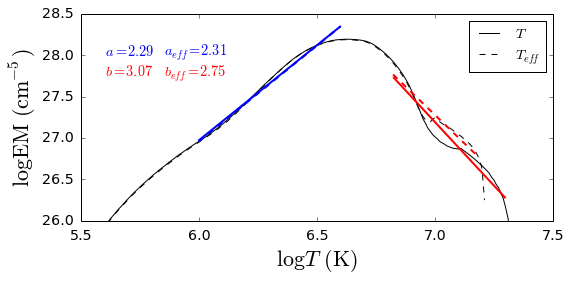

In [47]:
#plotting
fig = plt.figure(figsize=(8,4))
ax = fig.gca()
#plot EM curves
ax.plot(binner.logT_EM,binner.em,'k',label=r'$T$')
ax.plot(binner.logT_EM,binner.em_eff,'--k',label=r'$T_{eff}$')
#plot fit lines
if logTc is not False:
    ax.plot(logTc,pc[0]*logTc+pc[1],'b',linewidth=2)
if logTh is not False:
    ax.plot(logTh,ph[0]*logTh+ph[1],'r',linewidth=2)
if logTc_eff is not False:
    ax.plot(logTc_eff,pc_eff[0]*logTc_eff+pc_eff[1],'--b',linewidth=2)
if logTh_eff is not False:
    ax.plot(logTh_eff,ph_eff[0]*logTh_eff+ph_eff[1],'--r',linewidth=2)
#limits
ax.set_xlim([5.5,7.5])
ax.set_ylim([26,28.5])
#print slope values
ax.annotate(r'$a=%.2f$'%(pc[0]),
           xy=(5.6,28.0),fontsize=0.65*22,color='b')
ax.annotate(r'$a_{eff}=%.2f$'%(pc_eff[0]),
           xy=(5.85,28.0),fontsize=0.65*22,color='b')
ax.annotate(r'$b=%.2f$'%np.fabs(ph[0]),
           xy=(5.6,27.75),fontsize=0.65*22,color='r')
ax.annotate(r'$b_{eff}=%.2f$'%np.fabs(ph_eff[0]),
           xy=(5.85,27.75),fontsize=0.65*22,color='r')
#labels and aesthetics
ax.tick_params(axis='both',labelsize=0.65*22,pad=8)
ax.set_xlabel(r'$\log{T}$ $\mathrm{(K)}$',fontsize=22)
ax.set_ylabel(r'$\log{\mathrm{EM}}$ $(\mathrm{cm}^{-5})$',fontsize=22)
ax.legend(loc='best',fontsize=0.65*22)
#show and print
plt.tight_layout()
#plt.savefig('/home/wtb2/Documents/papers/hot_non-flaring_plasma_2/figures/teff_electron_em.pdf',
 #          format='pdf',dpi=1000)
plt.show()

Temperature bins not yet created. Building now with default values.


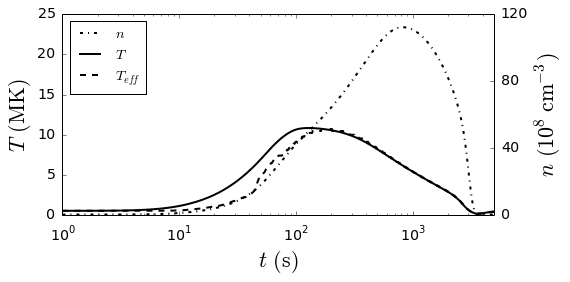

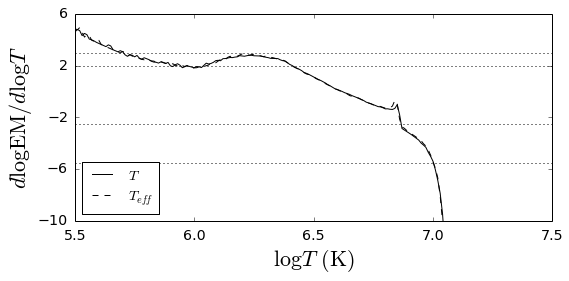

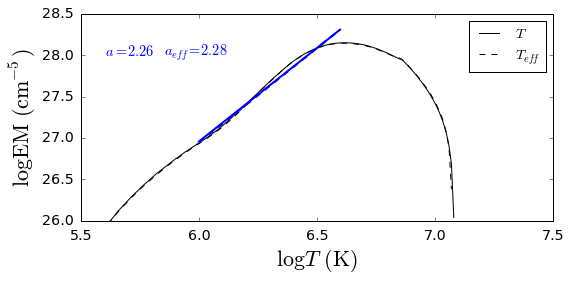

In [48]:
#ion
binner = emb.EM_Binner('ebtel_data/hp2_sp-test-case_ion_teff.txt',2*40.0e+8)
binner.build_em_dist()
#reduce by 10 for aspect ratio factor
binner.em = binner.em - 1.0
ionem = [binner.logT_EM,binner.em,binner.time,binner.temp,binner.density]
binner.em_eff = binner.em_eff - 1.0
#profiles
ion_pop_t_plotter('ebtel_data/hp2_sp-test-case_ion_teff.txt')#,
                 #fn='/home/wtb2/Documents/papers/hot_non-flaring_plasma_2/figures/teff_ion_profiles.pdf')
#derivatives
plot_derivs(binner.logT_EM,binner.em,binner.em_eff)
#fitting
logTc,pc,logTh,ph = mini_fitter(binner.logT_EM,binner.em)
logTc_eff,pc_eff,logTh_eff,ph_eff = mini_fitter(binner.logT_EM,
                                                binner.em_eff)
#plotting
fig = plt.figure(figsize=(8,4))
ax = fig.gca()
#plot EM curves
ax.plot(binner.logT_EM,binner.em,'k',label=r'$T$')
ax.plot(binner.logT_EM,binner.em_eff,'--k',label=r'$T_{eff}$')
#plot fit lines
if logTc is not False:
    ax.plot(logTc,pc[0]*logTc+pc[1],'b',linewidth=2)
#if logTh is not False:
#   ax.plot(logTh,ph[0]*logTh+ph[1],'r',linewidth=2)
if logTc_eff is not False:
    ax.plot(logTc_eff,pc_eff[0]*logTc_eff+pc_eff[1],'--b',linewidth=2)
#if logTh_eff is not False:
#    ax.plot(logTh_eff,ph_eff[0]*logTh_eff+ph_eff[1],'--r',linewidth=2)
#limits
ax.set_xlim([5.5,7.5])
ax.set_ylim([26,28.5])
#print slope values
ax.annotate(r'$a=%.2f$'%(pc[0]),
           xy=(5.6,28.0),fontsize=0.65*22,color='b')
ax.annotate(r'$a_{eff}=%.2f$'%(pc_eff[0]),
           xy=(5.85,28.0),fontsize=0.65*22,color='b')
#labels and aesthetics
ax.tick_params(axis='both',labelsize=0.65*22,pad=8)
ax.set_xlabel(r'$\log{T}$ $\mathrm{(K)}$',fontsize=22)
ax.set_ylabel(r'$\log{\mathrm{EM}}$ $(\mathrm{cm}^{-5})$',fontsize=22)
ax.legend(loc='best',fontsize=0.65*22)
#show and print
plt.tight_layout()
#plt.savefig('/home/wtb2/Documents/papers/hot_non-flaring_plasma_2/figures/teff_ion_em.pdf',
   #        format='pdf',dpi=1000)
plt.show()

Temperature bins not yet created. Building now with default values.


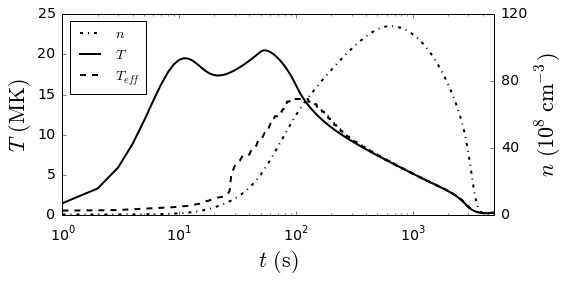

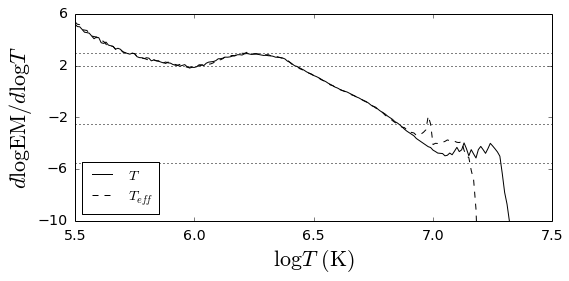

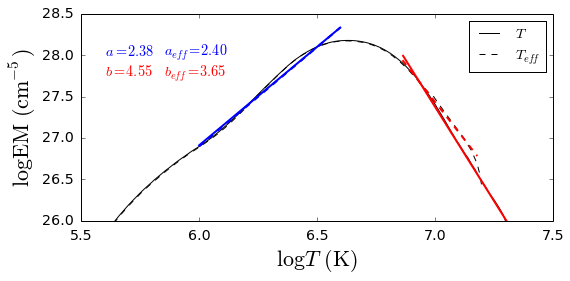

In [49]:
#single
binner = emb.EM_Binner('ebtel_data/hp2_sp-test-case_single_teff.txt',2*40.0e+8)
binner.build_em_dist()
#reduce by 10 for aspect ratio factor
binner.em = binner.em - 1.0
binner.em_eff = binner.em_eff - 1.0
sem = [binner.logT_EM,binner.em,binner.time,binner.temp,binner.density]
#profiles
ion_pop_t_plotter('ebtel_data/hp2_sp-test-case_single_teff.txt')#,
                 #fn='/home/wtb2/Documents/papers/hot_non-flaring_plasma_2/figures/teff_single_profiles.pdf')
#derivatives
plot_derivs(binner.logT_EM,binner.em,binner.em_eff)
#fitting
logTc,pc,logTh,ph = mini_fitter(binner.logT_EM,binner.em)
logTc_eff,pc_eff,logTh_eff,ph_eff = mini_fitter(binner.logT_EM,
                                                binner.em_eff)
#plotting
fig = plt.figure(figsize=(8,4))
ax = fig.gca()
#plot EM curves
ax.plot(binner.logT_EM,binner.em,'k',label=r'$T$')
ax.plot(binner.logT_EM,binner.em_eff,'--k',label=r'$T_{eff}$')
#plot fit lines
if logTc is not False:
    ax.plot(logTc,pc[0]*logTc+pc[1],'b',linewidth=2)
if logTh is not False:
    ax.plot(logTh,ph[0]*logTh+ph[1],'r',linewidth=2)
if logTc_eff is not False:
    ax.plot(logTc_eff,pc_eff[0]*logTc_eff+pc_eff[1],'--b',linewidth=2)
if logTh_eff is not False:
    ax.plot(logTh_eff,ph_eff[0]*logTh_eff+ph_eff[1],'--r',linewidth=2)
#limits
ax.set_xlim([5.5,7.5])
ax.set_ylim([26,28.5])
#print slope values
ax.annotate(r'$a=%.2f$'%(pc[0]),
           xy=(5.6,28.0),fontsize=0.65*22,color='b')
ax.annotate(r'$a_{eff}=%.2f$'%(pc_eff[0]),
           xy=(5.85,28.0),fontsize=0.65*22,color='b')
ax.annotate(r'$b=%.2f$'%np.fabs(ph[0]),
           xy=(5.6,27.75),fontsize=0.65*22,color='r')
ax.annotate(r'$b_{eff}=%.2f$'%np.fabs(ph_eff[0]),
           xy=(5.85,27.75),fontsize=0.65*22,color='r')
#labels and aesthetics
ax.tick_params(axis='both',labelsize=0.65*22,pad=8)
ax.set_xlabel(r'$\log{T}$ $\mathrm{(K)}$',fontsize=22)
ax.set_ylabel(r'$\log{\mathrm{EM}}$ $(\mathrm{cm}^{-5})$',fontsize=22)
ax.legend(loc='best',fontsize=0.65*22)
#show and print
plt.tight_layout()
#plt.savefig('/home/wtb2/Documents/papers/hot_non-flaring_plasma_2/figures/teff_single_em.pdf',
 #          format='pdf',dpi=1000)
plt.show()

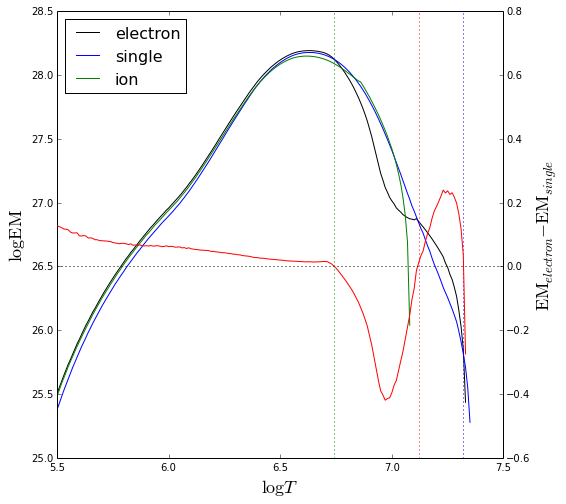

In [50]:
ax = plt.figure(figsize=(8,8)).gca()
ax.plot(elem[0],elem[1],'k',label=r'electron')
ax.plot(sem[0],sem[1],'b',label=r'single')
ax.plot(ionem[0],ionem[1],'g',label=r'ion')
axe = ax.twinx()
axe.plot(elem[0],(elem[1]-sem[1]),'r')
axe.axhline(y=0,linestyle='dotted',color='k')
ax.axvline(x=7.12,linestyle='dotted',color='r')
ax.axvline(x=7.32,linestyle='dotted',color='b')
ax.axvline(x=6.74,linestyle='dotted',color='g')
ax.set_ylim([25,28.5])
ax.set_xlim([5.5,7.5])
axe.set_xlim([5.5,7.5])
ax.set_xlabel(r'$\log{T}$',fontsize=18)
ax.set_ylabel(r'$\log{\mathrm{EM}}$',fontsize=18)
axe.set_ylabel(r'$\mathrm{EM}_{electron}-\mathrm{EM}_{single}$',fontsize=18)
ax.legend(loc='best',fontsize=16)
plt.show()

In [51]:
deps = (elem[1] - sem[1])
elem[0][np.where((deps>0))]

array([ 5.08,  5.09,  5.1 ,  5.11,  5.12,  5.13,  5.14,  5.15,  5.16,
        5.17,  5.18,  5.19,  5.2 ,  5.21,  5.22,  5.23,  5.24,  5.25,
        5.26,  5.27,  5.28,  5.29,  5.3 ,  5.31,  5.32,  5.33,  5.34,
        5.35,  5.36,  5.37,  5.38,  5.39,  5.4 ,  5.41,  5.42,  5.43,
        5.44,  5.45,  5.46,  5.47,  5.48,  5.49,  5.5 ,  5.51,  5.52,
        5.53,  5.54,  5.55,  5.56,  5.57,  5.58,  5.59,  5.6 ,  5.61,
        5.62,  5.63,  5.64,  5.65,  5.66,  5.67,  5.68,  5.69,  5.7 ,
        5.71,  5.72,  5.73,  5.74,  5.75,  5.76,  5.77,  5.78,  5.79,
        5.8 ,  5.81,  5.82,  5.83,  5.84,  5.85,  5.86,  5.87,  5.88,
        5.89,  5.9 ,  5.91,  5.92,  5.93,  5.94,  5.95,  5.96,  5.97,
        5.98,  5.99,  6.  ,  6.01,  6.02,  6.03,  6.04,  6.05,  6.06,
        6.07,  6.08,  6.09,  6.1 ,  6.11,  6.12,  6.13,  6.14,  6.15,
        6.16,  6.17,  6.18,  6.19,  6.2 ,  6.21,  6.22,  6.23,  6.24,
        6.25,  6.26,  6.27,  6.28,  6.29,  6.3 ,  6.31,  6.32,  6.33,
        6.34,  6.35,

In [52]:
def thermal_conduction_timescale(n,temp,L,species):
    if species is 'ion':
        kappa=3.2e-8
    elif species is 'electron':
        kappa=7.8e-7
    numer = 3.0*n*ac.k_B.cgs.value*L**2
    denom = 2.0*(kappa)*(temp)**(5.0/2.0)
    return numer/denom

def coupling_timescale(n,t_e):
    term1 = 3.0*ac.m_e.cgs.value*ac.m_p.cgs.value
    term2 = 16.0*(ac.e.gauss.value)**4*np.sqrt(np.pi)
    term3 = (2.0*ac.k_B.cgs.value*t_e/ac.m_e.cgs.value)**(3/2)
    term4 = n*20
    return term1/term2*term3/term4

In [53]:
ccs = []
tcs = []
for i in range(len(elem[2])):
    ccs.append(coupling_timescale(elem[4][i],elem[3][i]))
    tcs.append(thermal_conduction_timescale(elem[4][i],elem[3][i],40.0e+8,'electron'))

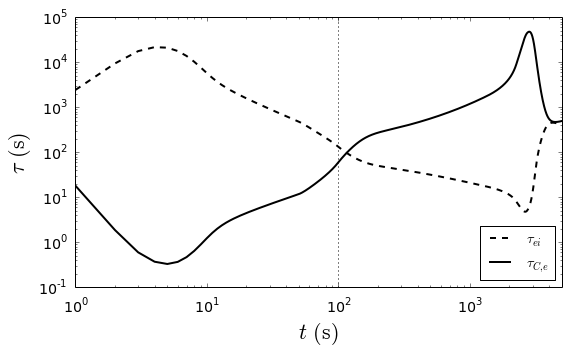

In [54]:
fig = plt.figure(figsize=(8,5))
ax = fig.gca()
ax.plot(elem[2],ccs,'k--',linewidth=2,label=r'$\tau_{ei}$')
ax.plot(elem[2],tcs,'k-',linewidth=2,label=r'$\tau_{C,e}$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([elem[2][0],elem[2][-1]])
ax.tick_params(axis='both',labelsize=0.65*22,pad=8)
ax.axvline(x=100,linestyle='dotted',color='k')
ax.set_xlabel(r'$t$ $\mathrm{(s)}$',fontsize=22)
ax.set_ylabel(r'$\tau$ $\mathrm{(s)}$',fontsize=22)
ax.legend(fontsize=0.65*22,loc='best')
plt.tight_layout()
plt.savefig('/home/wtb2/Documents/papers/hot_non-flaring_plasma_2/figures/electron_ts_compare.pdf',
           format='pdf',dpi=1000)
plt.show()

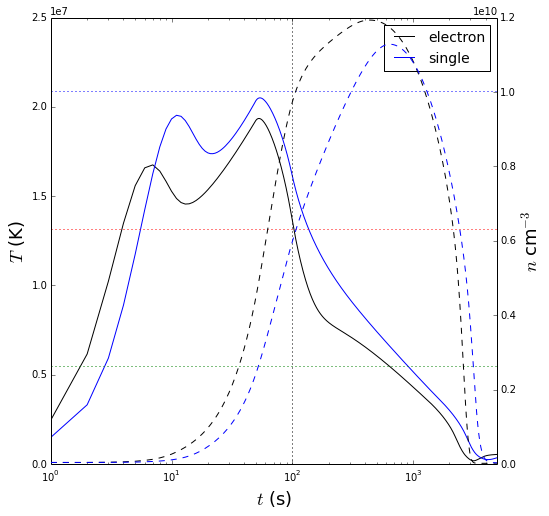

In [55]:
ax = plt.figure(figsize=(8,8)).gca()
axn = ax.twinx()
ax.plot(elem[2],elem[3],'k',label=r'electron')
axn.plot(elem[2],elem[4],'--k')
ax.plot(sem[2],sem[3],'b',label=r'single')
axn.plot(sem[2],sem[4],'--b')
ax.set_xscale('log')
axn.set_xscale('log')
ax.set_xlabel(r'$t$ (s)',fontsize=18)
ax.set_ylabel(r'$T$ (K)',fontsize=18)
axn.set_ylabel(r'$n$ cm$^{-3}$',fontsize=18)
ax.legend(loc='best',fontsize=14)
#axn.set_yscale('log')
#ax.set_yscale('log')
ax.set_xlim([0,elem[2][-1]])
axn.set_xlim([0,elem[2][-1]])
ax.axhline(y=10**(7.12),linestyle='dotted',color='r')
ax.axhline(y=10**(7.32),linestyle='dotted',color='b')
ax.axhline(y=10**(6.74),linestyle='dotted',color='g')
#axn.axhline(y=10**(9.5),linestyle='-.',color='k')
ax.axvline(x=100,linestyle='dotted',color='k')
#ax.axvline(x=elem[2][np.argmax(elem[4])],linestyle='dotted',color='k')
#ax.axvline(x=sem[2][np.argmax(sem[4])],linestyle='dotted',color='k')
plt.show()

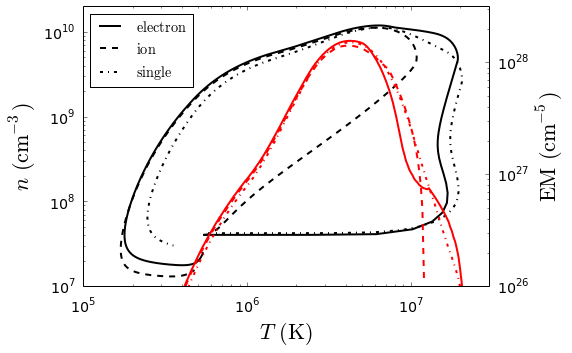

In [56]:
fig = plt.figure(figsize=(8,5))
ax = fig.gca()
axem = ax.twinx()
ax.plot(elem[3],elem[4],'k',linewidth=2,label=r'$\mathrm{electron}$')
ax.plot(ionem[3],ionem[4],'k--',linewidth=2,label=r'$\mathrm{ion}$')
ax.plot(sem[3],sem[4],'k-.',linewidth=2,label=r'$\mathrm{single}$')
axem.plot(10**elem[0],10**elem[1],linestyle='-',linewidth=2,
          color=sns.xkcd_palette(['fire engine red'])[0])
axem.plot(10**ionem[0],10**ionem[1],linestyle='--',linewidth=2,
          color=sns.xkcd_palette(['fire engine red'])[0])
axem.plot(10**sem[0],10**sem[1],linestyle='-.',linewidth=2,
          color=sns.xkcd_palette(['fire engine red'])[0])
ax.set_xlabel(r'$T$ $\mathrm{(K)}$',fontsize=22)
ax.set_ylabel(r'$n$ $(\mathrm{cm}^{-3})$',fontsize=22)
axem.set_ylabel(r'$\mathrm{EM}$ $(\mathrm{cm}^{-5})$',fontsize=22)
ax.set_xscale('log')
axem.set_xscale('log')
ax.set_yscale('log')
axem.set_yscale('log')
ax.set_xlim([10**5,3*10**7])
ax.set_ylim([10**7,2*10**10])
axem.set_xlim([10**5,3*10**7])
axem.set_ylim([10**26.0,10**28.5])
ax.tick_params(axis='both',labelsize=0.65*22,pad=8)
axem.tick_params(axis='both',labelsize=0.65*22,pad=8)
ax.legend(loc=2,fontsize=0.65*22)
plt.tight_layout()
plt.savefig('/home/wtb2/Documents/papers/hot_non-flaring_plasma_2/figures/electron_single_nt_compare.pdf',
           format='pdf',dpi=1000)
plt.show()